In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style = 'darkgrid', font_scale = 1.5)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
from dataclasses import dataclass

@dataclass
class DialogueData:
    def _get_second_stage_emb(self, dial, data, embeddings, graph):
        start_idx = data.get_dialog_start_idx(dial)
        self.clusters = []
        self.second_stage_emb = []
        for i in range(len(dial.utterances)):
            lm_embedd = embeddings[start_idx + i, :].ravel()
            cluster = graph.one_stage_clustering.predict_cluster(lm_embedd, dial[i], dial).id
            self.second_stage_emb.append(graph.cluster_embeddings[cluster])
            self.clusters.append(cluster)

    def __init__(self, dial, data, embeddings, graph):
        utts = [str(utt) for utt in dial.utterances]
        r =  ".".join(utts) + "."
        self.str = r
        self.services = dial.meta['services']
        self._get_second_stage_emb(dial, data,embeddings, graph)

In [3]:
with open("dialogue_sim/data/mwtrain_sbert.pkl", "rb") as file:
    mwtrain = pickle.load(file)

with open("dialogue_sim/data/mwtest_sbert.pkl", "rb") as file:
    mwtest = pickle.load(file)

In [4]:
clusters = {s for d in mwtrain for s in d.clusters}
n_clusters = len(clusters)

In [5]:
services = {s for d in mwtrain for s in d.services}
serv_to_idx = {s : i for i, s in enumerate(services)}

def serv_to_vec(services):
  ids = list(map(lambda x : serv_to_idx[x], services))
  vec = np.zeros(len(serv_to_idx))
  vec[ids] = 1
  return vec

class MultiWOZ(Dataset):
    MAX_LEN = 50
    EMB_DIM = 8

    def pad_emb(self, emb):
        if len(emb) > self.MAX_LEN:
            emb = emb[:self.MAX_LEN]
        if len(emb) < self.MAX_LEN:
            pad = np.zeros((self.MAX_LEN - len(emb), emb[0].shape[0]))
            return np.concatenate((emb, pad), axis = 0)
    
    def __init__(self, dials):
        self.clusters = np.array([self.__pad_clusters(d.clusters) for d in dials])
        self.embeddings = np.array([self.pad_emb(np.array(d.second_stage_emb)) for d in dials])
        self.lengths = np.array([len(d.second_stage_emb) for d in  dials])
        self.services = np.array([serv_to_vec(d.services) for d in dials])
        self.dials = dials
    
    def __pad_clusters(self, clusters):
        cl = np.array(clusters)
        res = np.ones(self.MAX_LEN) * n_clusters
        res[:cl.shape[0]] = cl
        return res

    def __pad_embeddings(self, embedds):
        res = np.zeros((self.MAX_LEN,self.EMB_DIM))
        res[:embedds.shape[0], :] = embedds
        return res
    
    def __len__(self):
        return len(self.dials)

    def __getitem__(self, idx):
        cur_dial = self.dials[idx]
        return {'text' : cur_dial.str, 'clusters' : self.clusters[idx], 'embeddings' : self.embeddings[idx],
                 'services' : self.services[idx], 'lengths' : self.lengths[idx]}

train = MultiWOZ(mwtrain)
test = MultiWOZ(mwtest)

train_loader = DataLoader(train, batch_size = 256, shuffle = True)
test_loader = DataLoader(test, batch_size = 256, shuffle = True)

## Second stage sbert embeddings + FFN

In [6]:
def get_scores(emb):
  norm = torch.linalg.norm(emb, axis = 1)
  sim = emb @ emb.T 
  sim /= norm.reshape(-1, 1)
  sim /= norm.reshape(1, -1) 
  n = sim.shape[0]
  return sim[np.triu_indices(n, 1)]

def get_targets(data):
  n = data.shape[0]
  return (data @ data.T > 0).float()[np.triu_indices(n, 1)]

In [7]:
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output

def plot_history(history):
    clear_output(wait=True)
    plt.figure(figsize = (18, 9))
    plt.subplot(1, 2, 1)
    sns.lineplot(x = history['iter'], y =history['loss'], label = "train")
    sns.lineplot(x = history['iter'], y = history['test_loss'], label = 'test')
    plt.title('Loss')
    plt.xlabel('iter no')
    plt.subplot(1, 2, 2)
    sns.lineplot(x = history['iter'], y =history['auc'], label = 'train')
    sns.lineplot(x = history['iter'], y =history['test_auc'], label = 'test')
    plt.title("auc")
    plt.xlabel('iter no')
    plt.show()

def train_cycle(model, train_loader = train_loader,
                optimizer = None, loss = None, num_epochs = 1, plot_iter = 2):
  if optimizer is None:
    optimizer = torch.optim.Adam(model.parameters())
  if loss is None:
    loss = nn.BCELoss()
  history = defaultdict(list)
  iteration = 0
  for epoch in range(num_epochs):
    for data in train_loader:
        serv = data['services']
        emb = data['embeddings'].to(device)
        l = data['lengths'].to(device)
        outp = model(data)
        del emb
        scores = get_scores(outp)
        del outp
        target = get_targets(serv)

        optimizer.zero_grad()
        l = loss((1 + scores) / (2.001), target.to(device))
        l.backward()
        optimizer.step()

        iteration += 1
        if iteration % plot_iter == 0:
          with torch.no_grad():
            data = next(iter(test_loader))
            serv = data['services']
            outp = model(data)
            test_scores = get_scores(outp.cpu())
            del outp
            test_target = get_targets(serv)
            test_l = loss((1 + test_scores) / 2.001, test_target)
            test_auc = roc_auc_score(test_target.cpu().detach().numpy(), (1 + test_scores.cpu().detach().numpy()) / 2.001)
            history['test_loss'].append(test_l.item())
            history['test_auc'].append(test_auc)

          auc = roc_auc_score(target.cpu().detach().numpy(), (1 + scores.cpu().detach().numpy()) / 2.001)
          history['iter'].append(iteration)
          history['loss'].append(l.item())
          history['auc'].append(auc)
          plot_history(history)

In [8]:
from tqdm.notebook import tqdm

def eval():
  with torch.no_grad():
    all_scores = np.array([])
    all_targets = np.array([])
    for data in tqdm(test_loader):
        serv = data['services']
        outp = model(data)
        scores = get_scores(outp.cpu())
        del outp
        target = get_targets(serv)

        all_scores = np.concatenate((all_scores, scores.cpu().detach().numpy()))
        all_targets = np.concatenate((all_targets, target.cpu().detach().numpy()))
  return all_scores, all_targets

In [28]:
import torch.nn as nn

class DialSimFFN(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(in_features = 8, out_features = 64)
    self.act = nn.GELU()
    self.l2 = nn.Linear(in_features = 64, out_features = 16)
  
  def forward(self, data):
    emb = data['embeddings'].to(device).float()
    l = data['lengths'].to(device)
    x = self.l1(emb.sum(axis = 1) / l.reshape(-1, 1))
    x = self.act(x)
    return self.l2(x)

model = DialSimFFN().to(device)

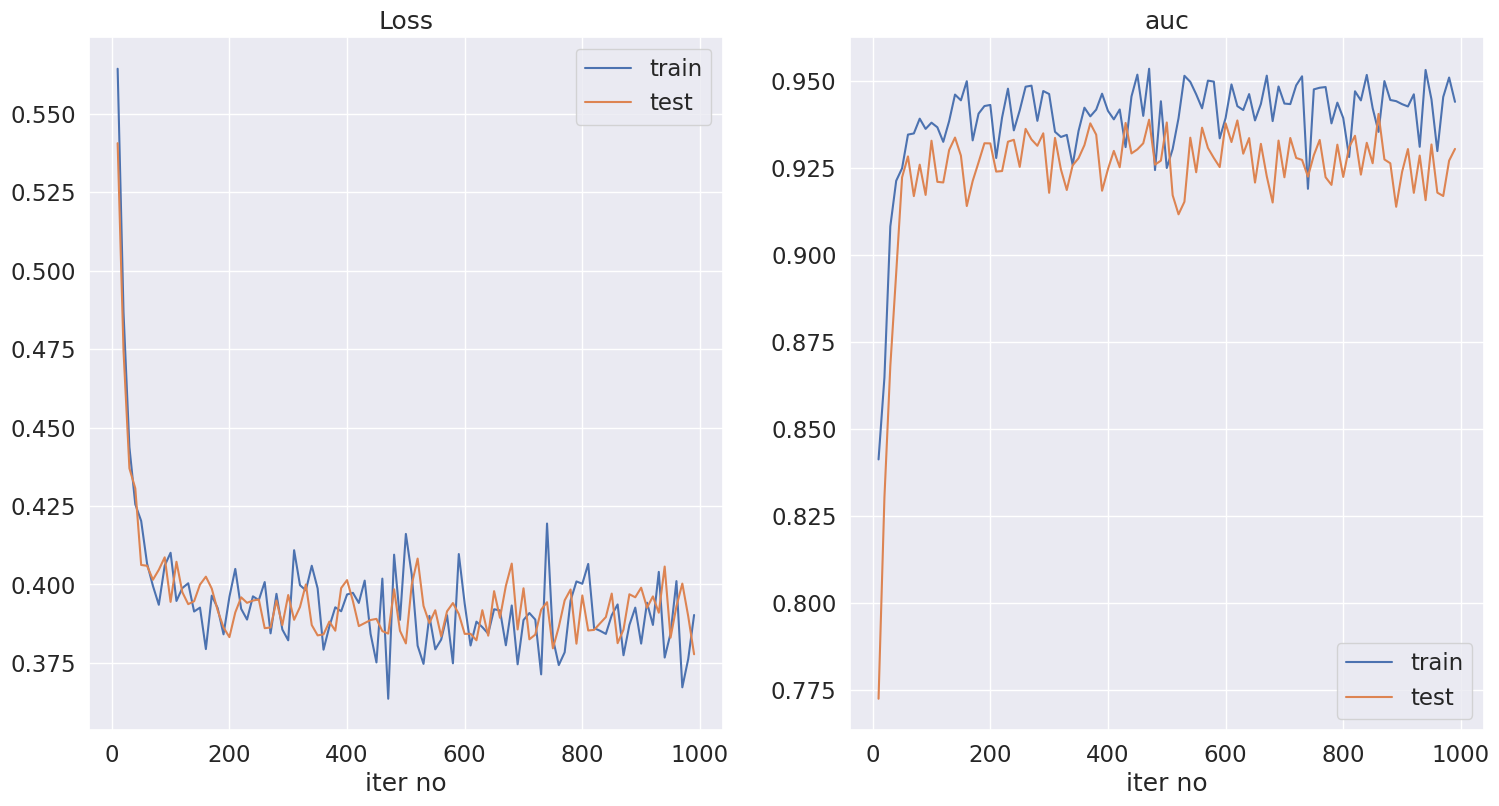

In [29]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 30, plot_iter = 10)

  0%|          | 0/4 [00:00<?, ?it/s]

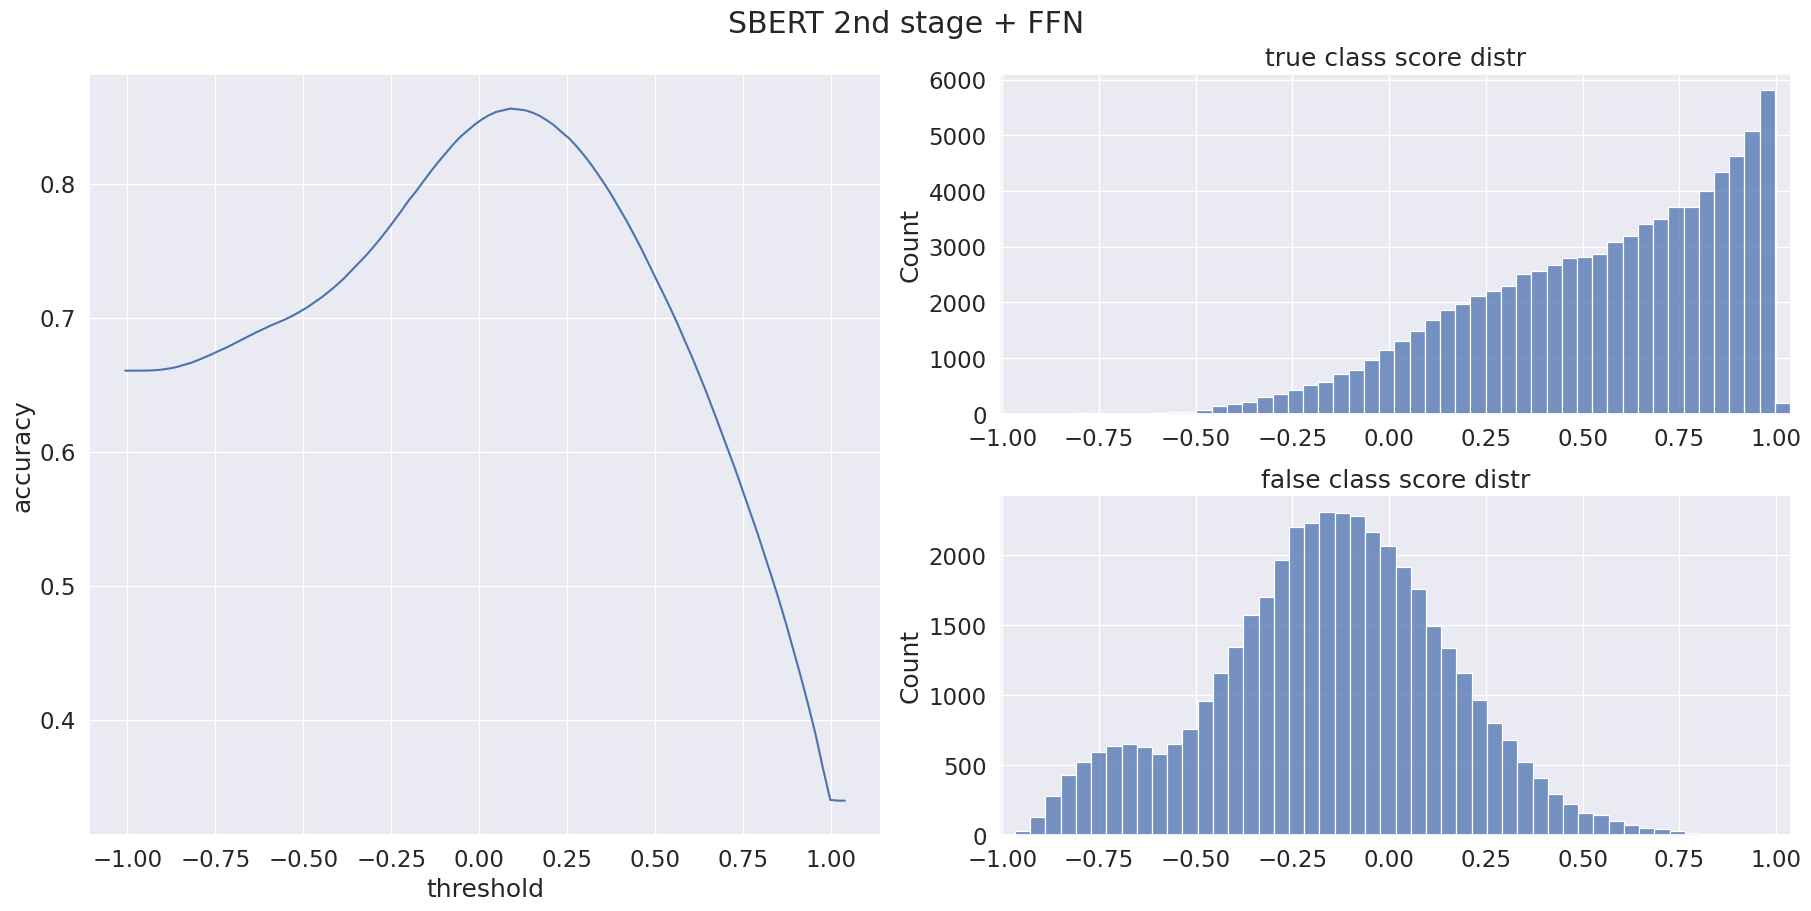

max acc: 0.856
class 1 prop : 0.6604284935373168


In [30]:
from dialogue_sim.utils import plot_pairwaise_class

res = {}
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "SBERT 2nd stage + FFN")
res['SBERT 2nd stage + FFN'] = max_acc

## Second stage sbert + RNN

In [31]:
class DialSimRNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.RNN(input_size = 8, hidden_size = 64, num_layers = 2, bidirectional = True)
  
  def forward(self, data):
    lengths = data['lengths'].cpu()
    emb = data['embeddings'].to(device).float()
    ps = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = False)
    return self.rnn(ps)[1][0]
  
model = DialSimRNN().to(device)

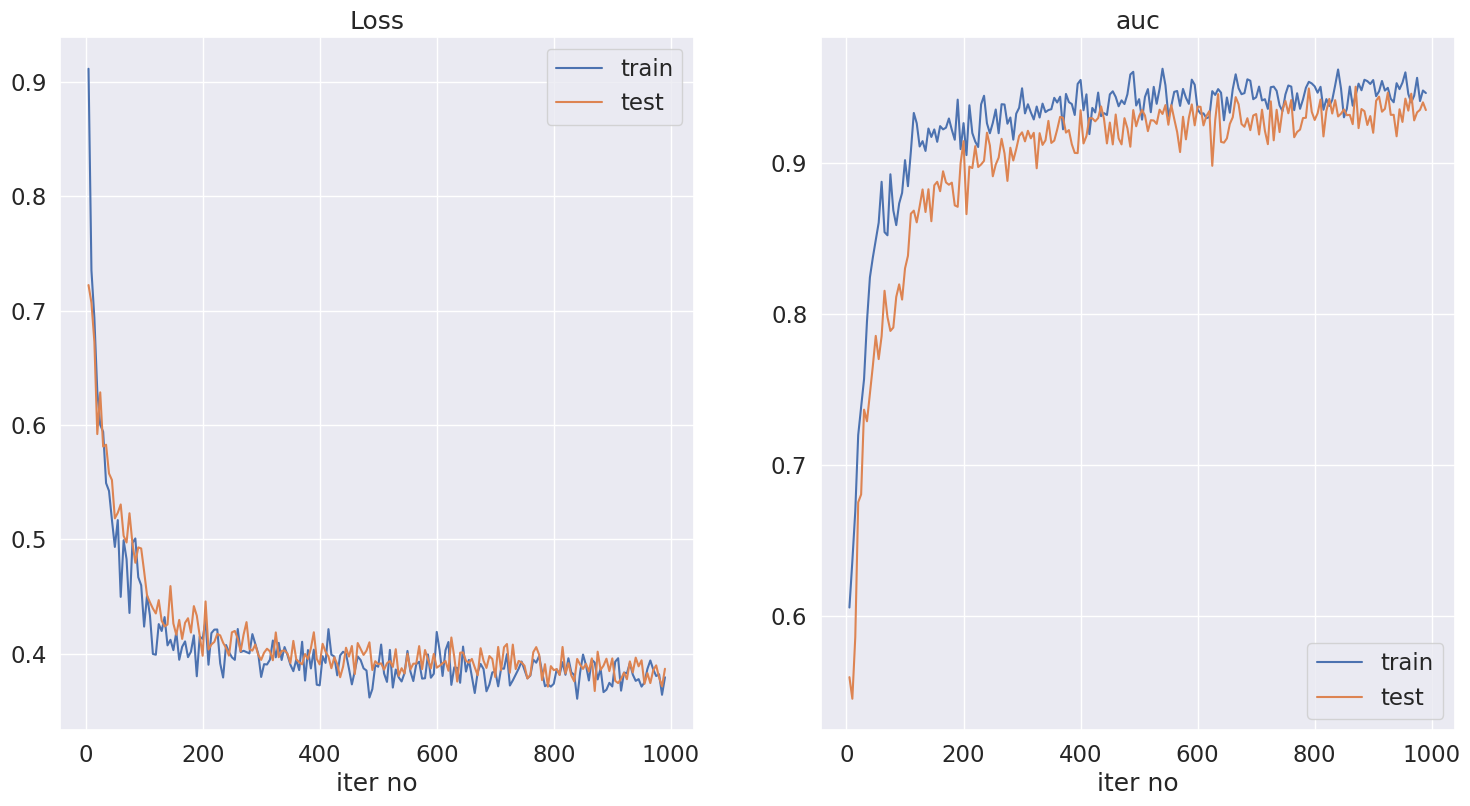

In [32]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 30, plot_iter = 5)

  0%|          | 0/4 [00:00<?, ?it/s]

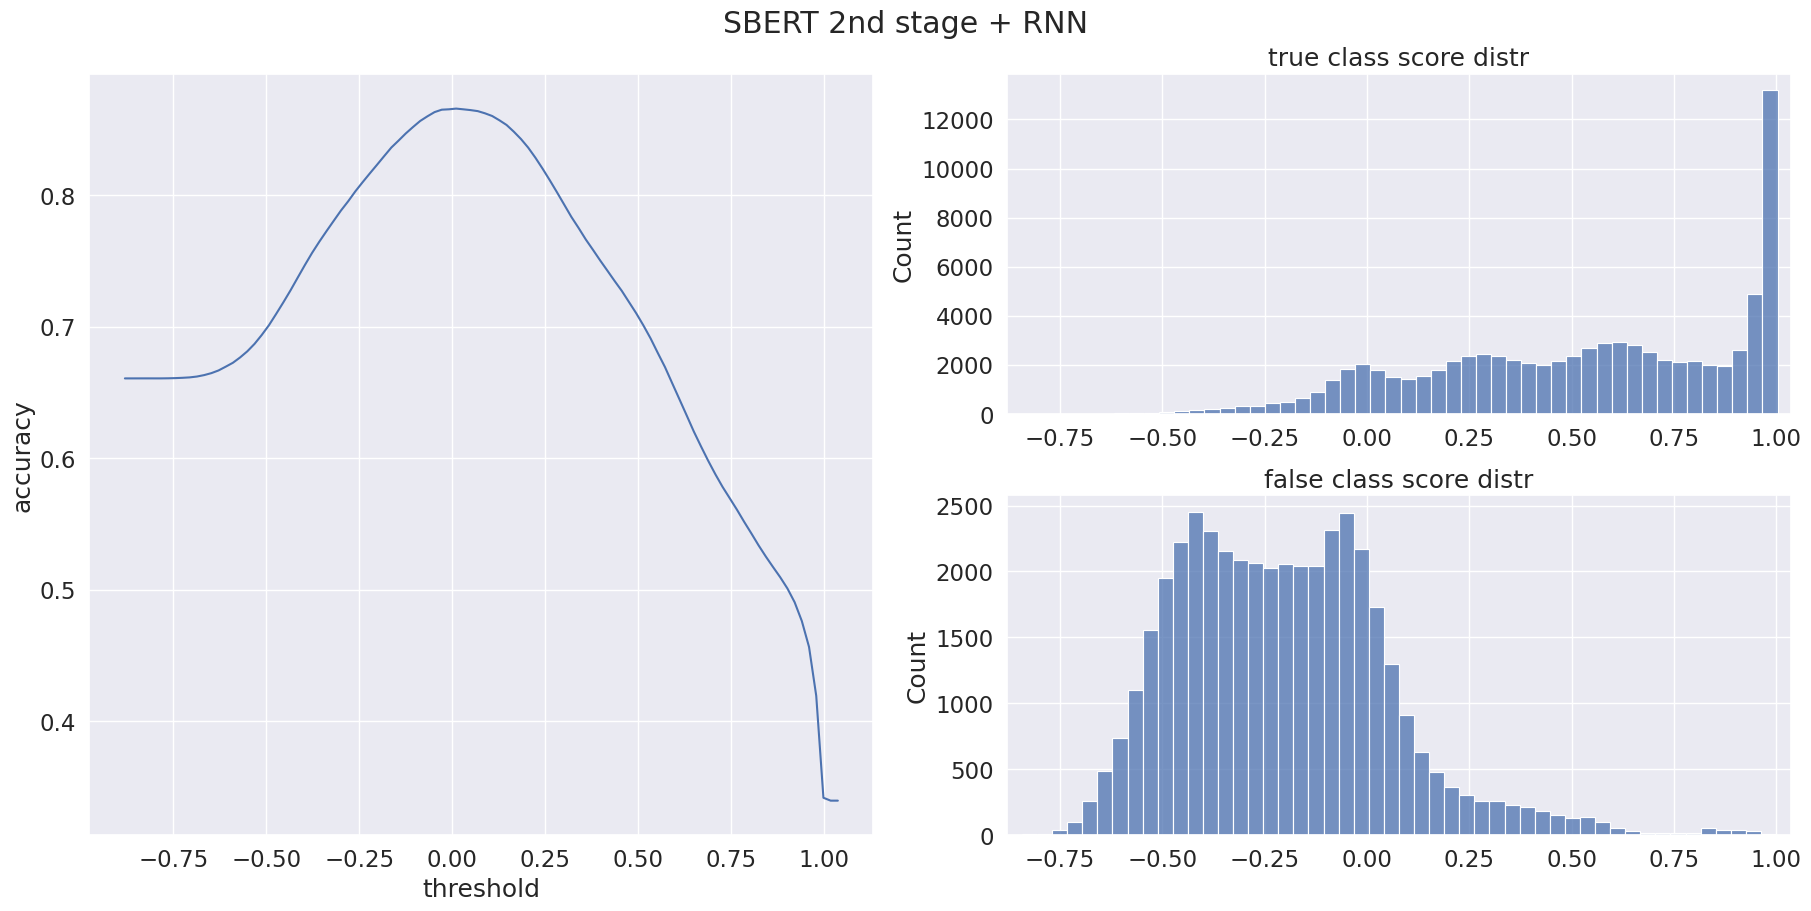

max acc: 0.866
class 1 prop : 0.6605808396677251


In [33]:
from dialogue_sim.utils import plot_pairwaise_class
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "SBERT 2nd stage + RNN")
res['SBERT 2nd stage + RNN'] = max_acc

## Second stage sbert + GRU

In [39]:
class DialSimGRU(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.GRU(input_size = 8, hidden_size = 64, num_layers = 2, bidirectional = True)
  
  def forward(self, data):
    lengths = data['lengths'].cpu()
    emb = data['embeddings'].to(device).float()
    ps = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = False)
    return self.rnn(ps)[1][0]
  
model = DialSimGRU().to(device)

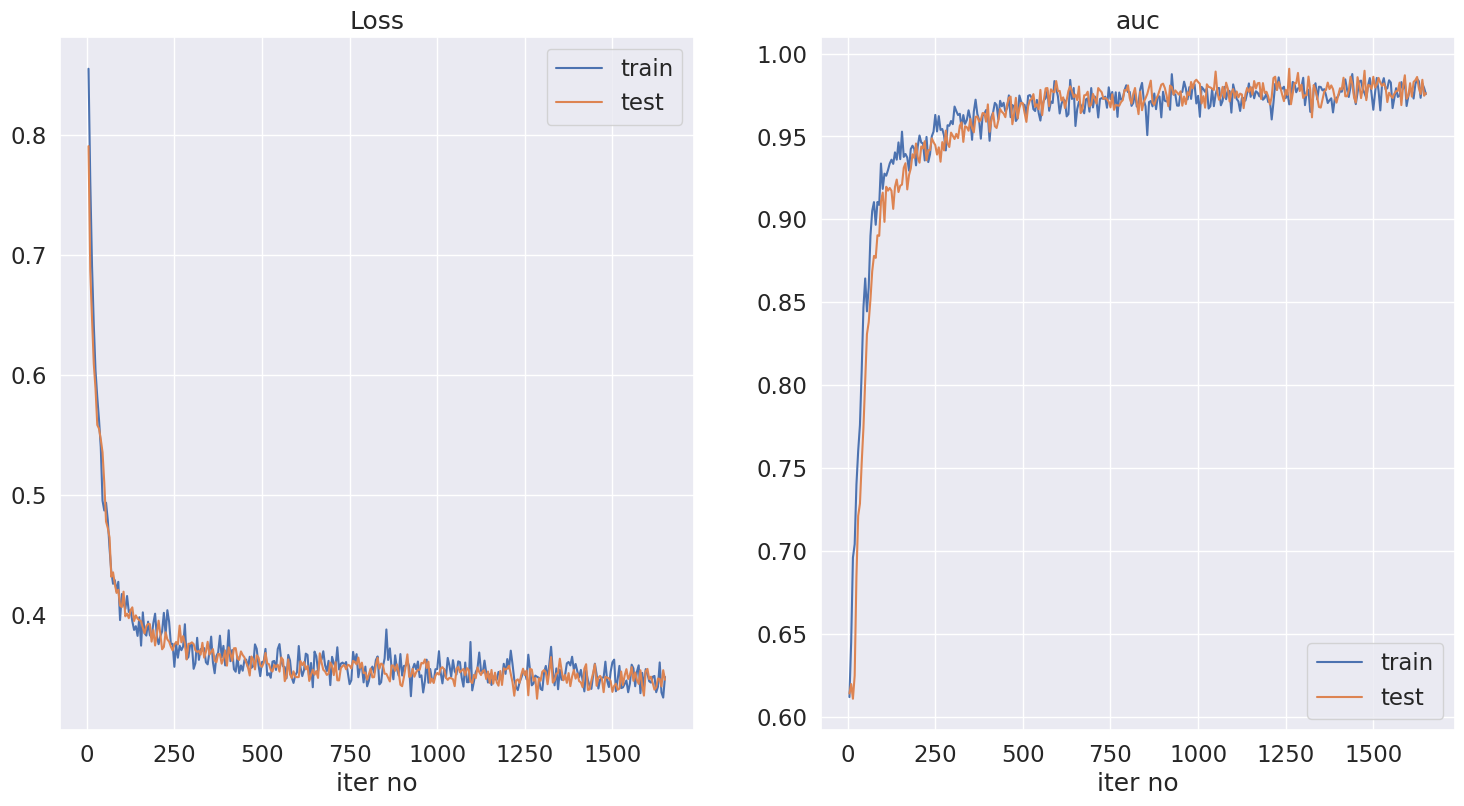

In [40]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 50, plot_iter = 5)

  0%|          | 0/4 [00:00<?, ?it/s]

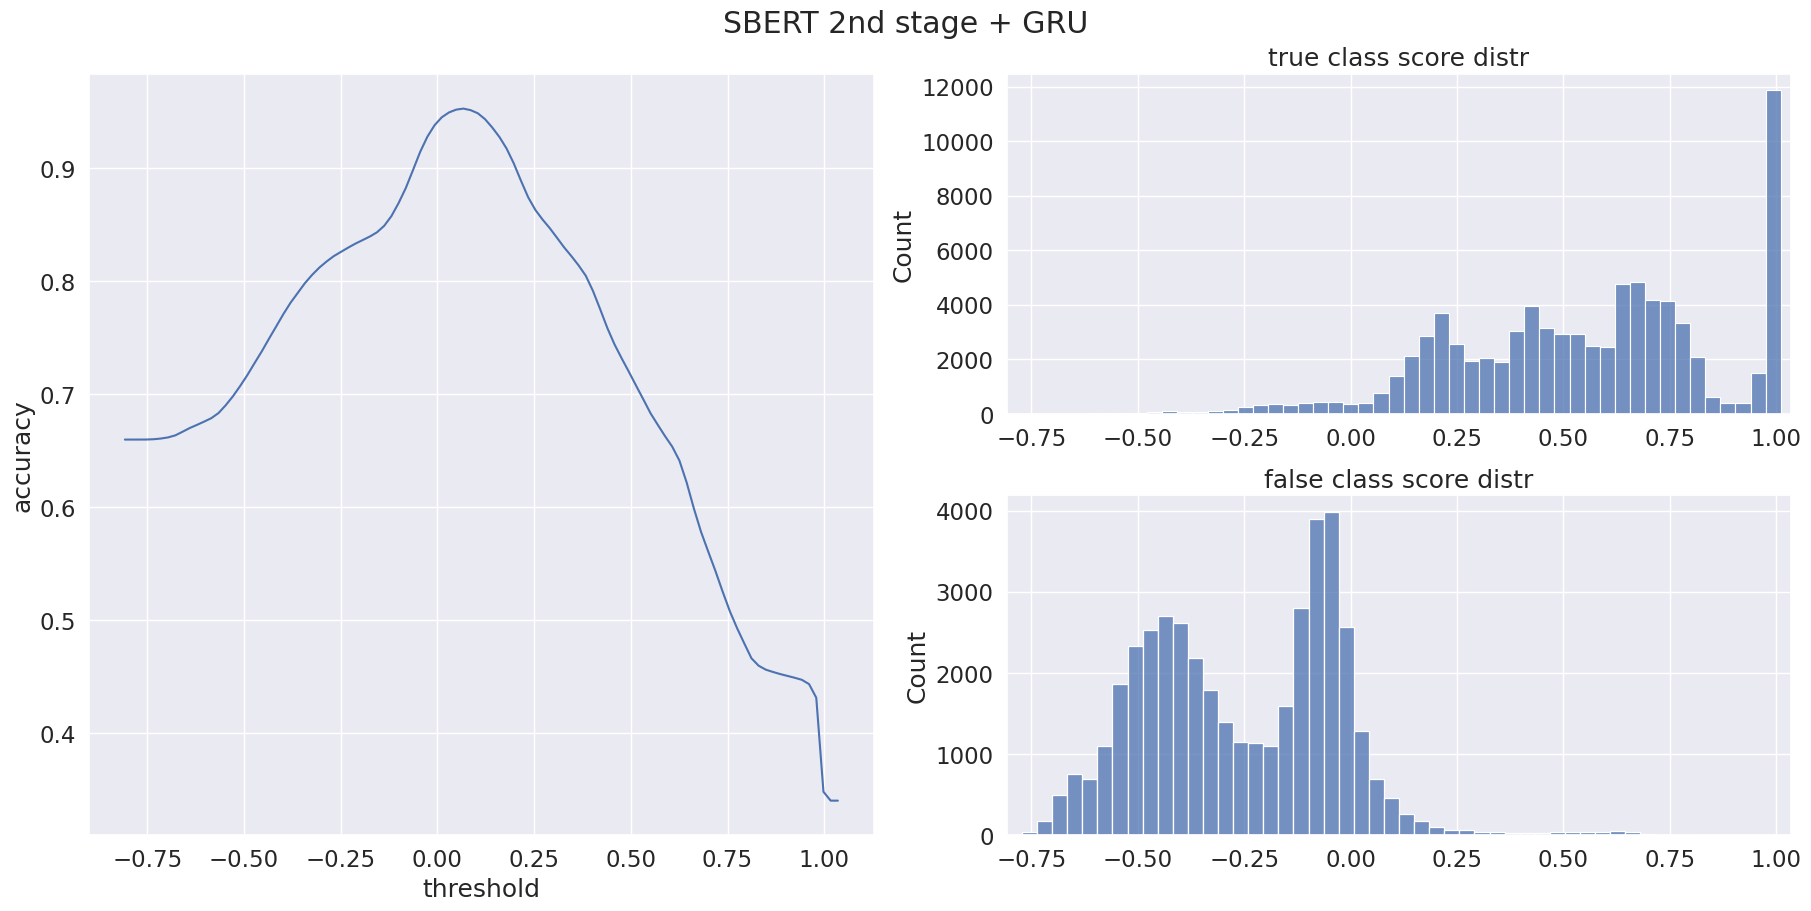

max acc: 0.953
class 1 prop : 0.6597709997113441


In [41]:
from dialogue_sim.utils import plot_pairwaise_class
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "SBERT 2nd stage + GRU")
res['SBERT 2nd stage + GRU'] = max_acc

## cluster + train emb + GRU

In [47]:
class DialSimGruEmb(nn.Module):
  EMB_DIM = 8

  def __init__(self):
    super().__init__()
    self.rnn = nn.GRU(input_size = self.EMB_DIM, hidden_size = 64, num_layers = 2, bidirectional = True)
    self.emb = nn.Embedding(n_clusters + 1, self.EMB_DIM, n_clusters)
  
  def forward(self, data):
    clusters = data['clusters'].to(device).to(torch.int64)
    emb = self.emb(clusters)
    lengths = data['lengths'].cpu()
    ps = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = False)
    return self.rnn(ps)[1][0]
  
model = DialSimGruEmb().to(device)

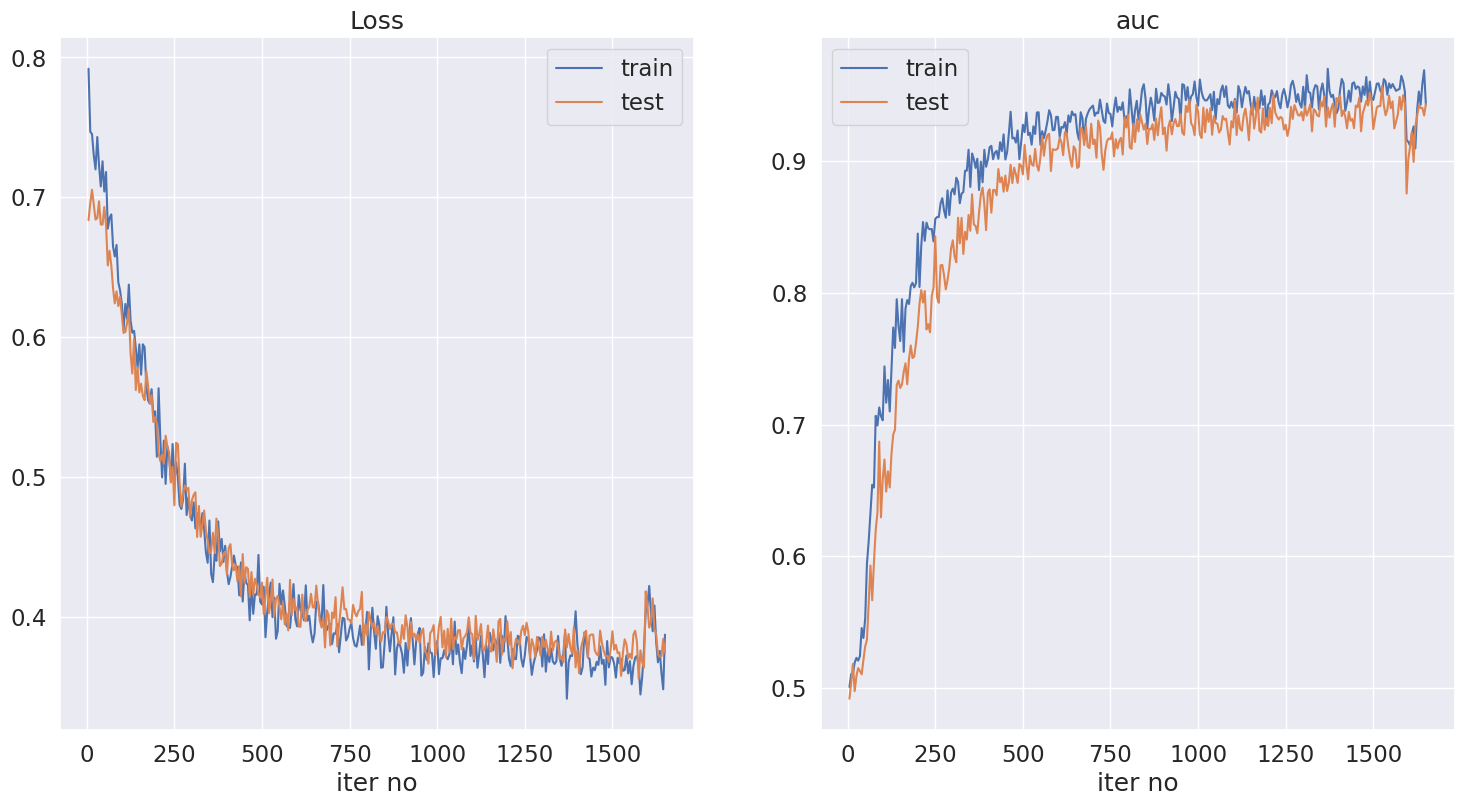

In [48]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 50, plot_iter = 5)

  0%|          | 0/4 [00:00<?, ?it/s]

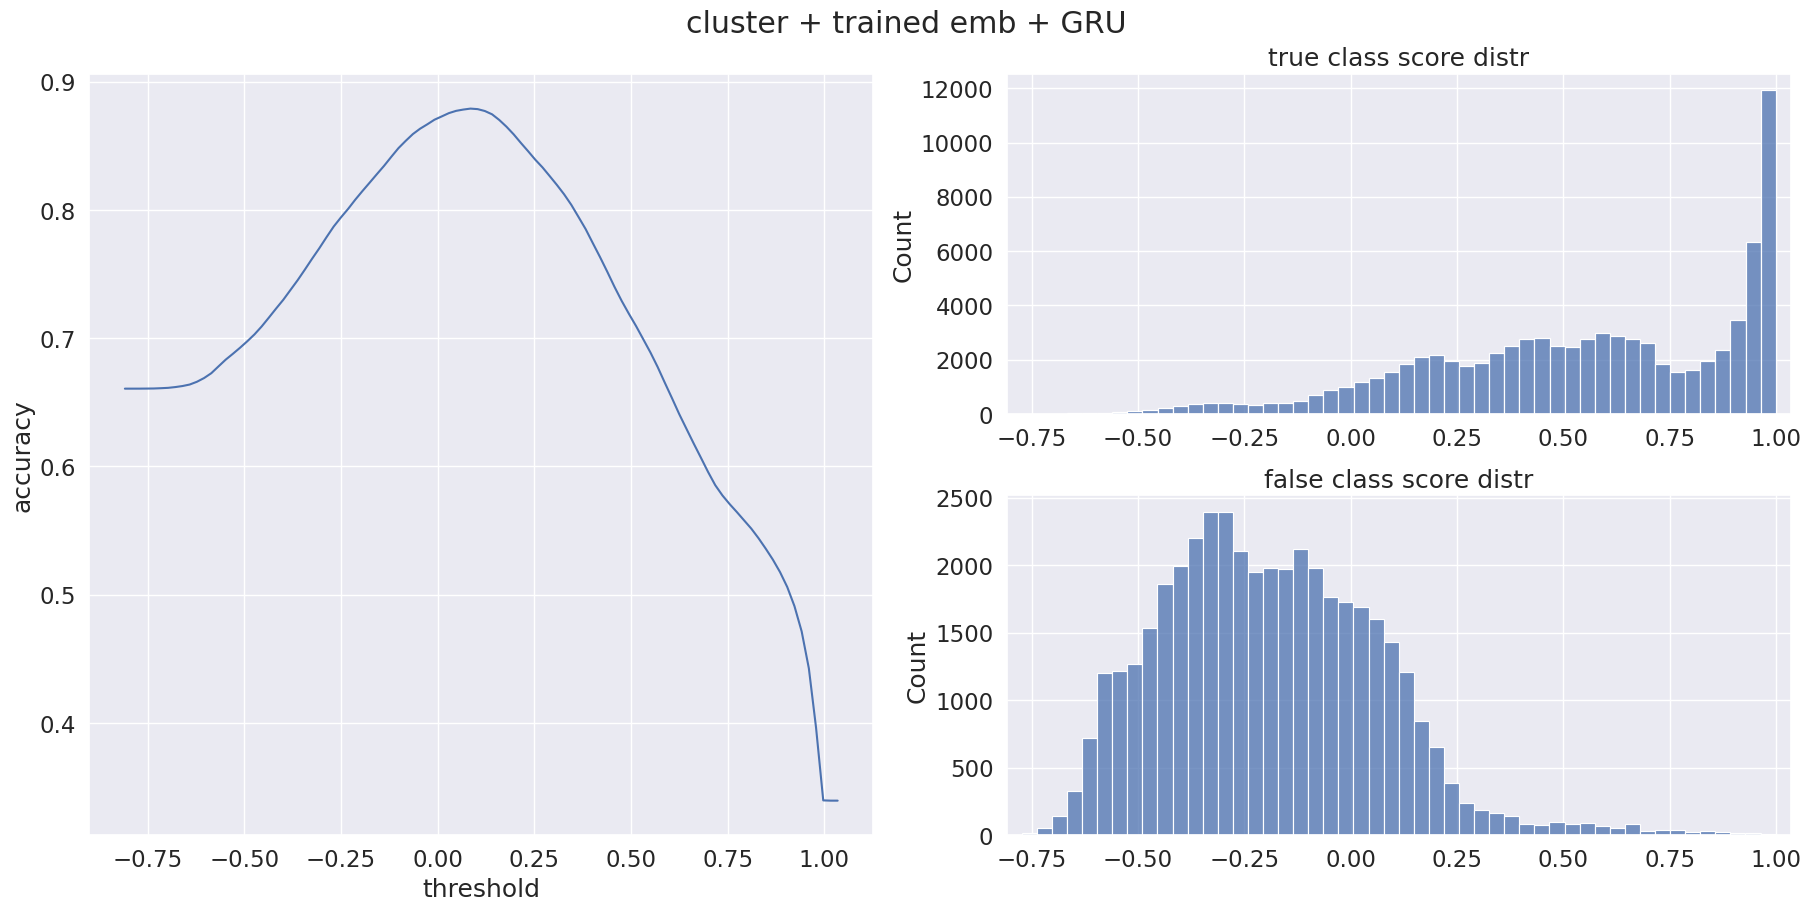

max acc: 0.879
class 1 prop : 0.6606369671894544


In [49]:
from dialogue_sim.utils import plot_pairwaise_class
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "cluster + trained emb + GRU")
res['cluster + trained emb + GRU'] = max_acc

## Second Stage SBERT + GRU + FFN

In [50]:
class DialSimGruFFN(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.GRU(input_size = 8, hidden_size = 64, num_layers = 2, bidirectional = True)
    self.l1 = nn.Linear(in_features = 64, out_features = 128)
    self.act = nn.GELU()
    self.l2 = nn.Linear(in_features = 128, out_features = 32)
  
  def forward(self, data):
    lengths = data['lengths'].cpu()
    emb = data['embeddings'].to(device).float()
    ps = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = False)
    h = self.rnn(ps)[1][0]
    x = self.l1(h)
    x = self.act(x)
    x = self.l2(x)
    return x
  
model = DialSimGruFFN().to(device)

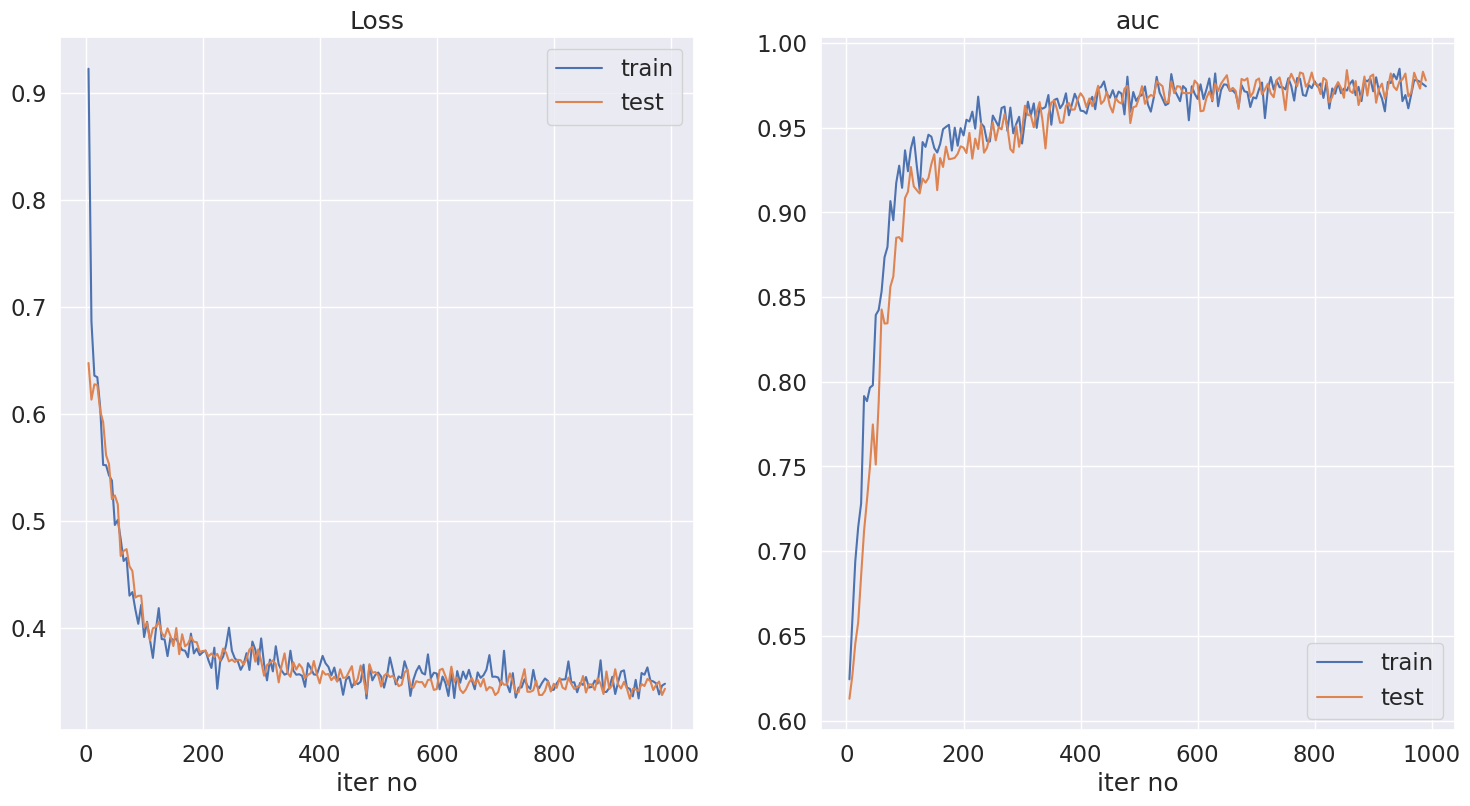

In [51]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 30, plot_iter = 5)

  0%|          | 0/4 [00:00<?, ?it/s]

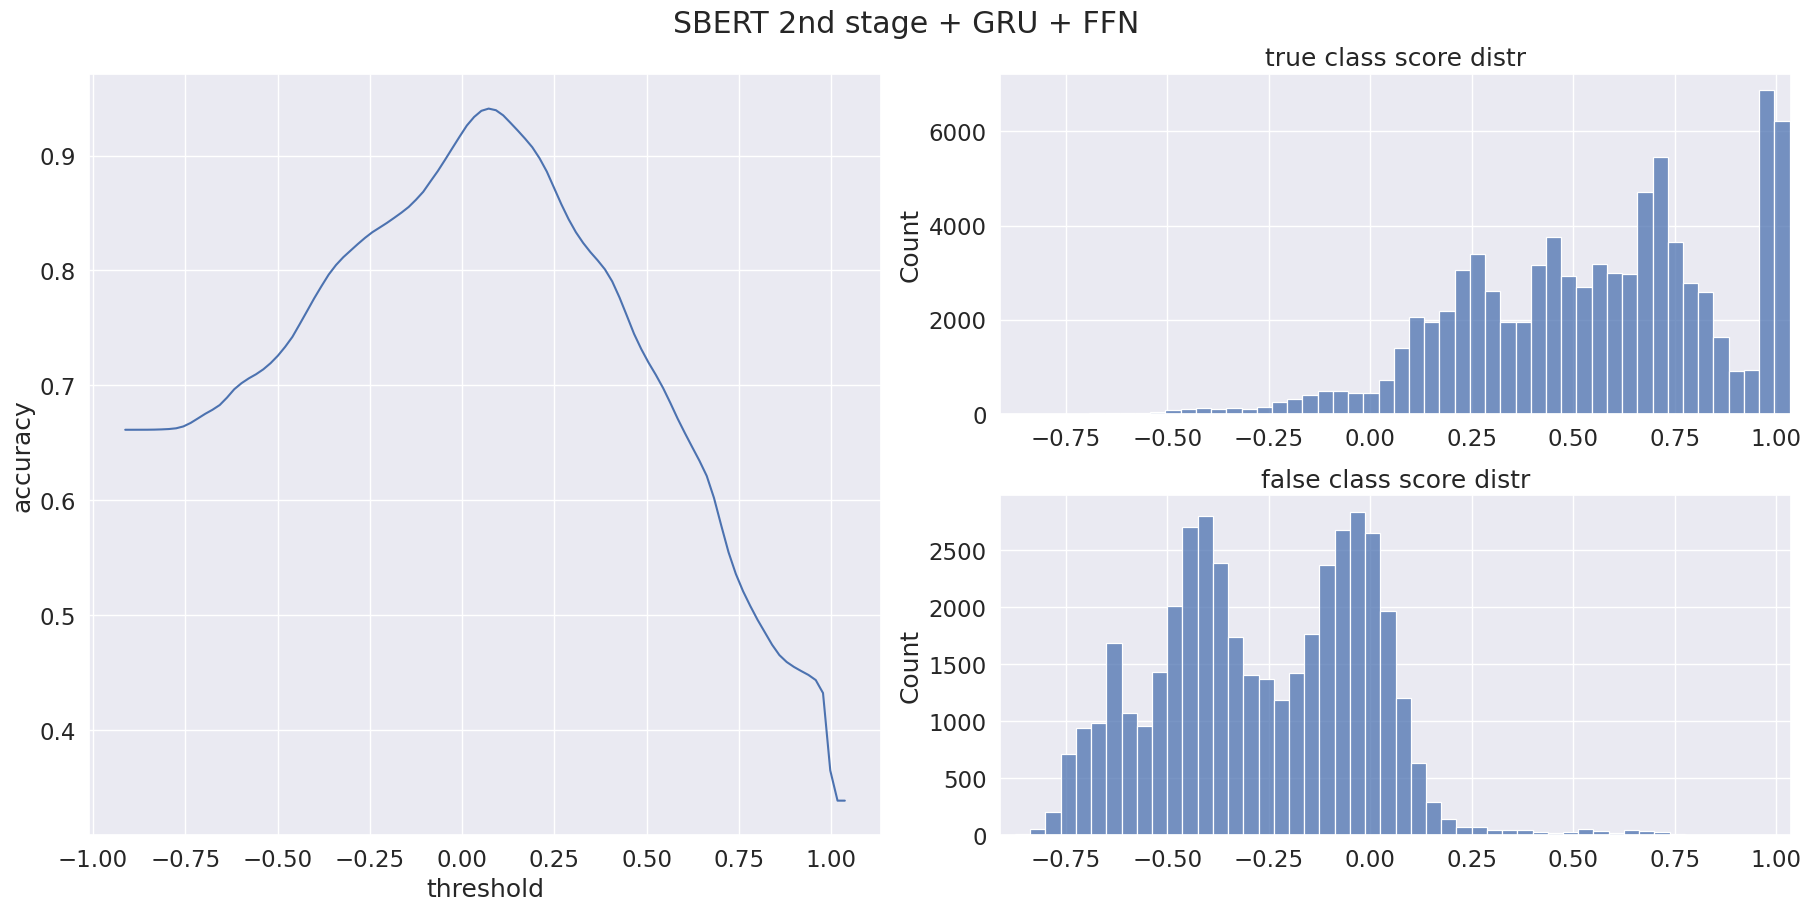

max acc: 0.941
class 1 prop : 0.6613666249719362


In [52]:
from dialogue_sim.utils import plot_pairwaise_class
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "SBERT 2nd stage + GRU + FFN")
res['SBERT 2nd stage + GRU + FFN'] = max_acc

## Second stage SBERT + LSTM

In [53]:
import torch.nn as nn
class DialSimLSTM(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.LSTM(input_size = 8, hidden_size = 64, num_layers = 1, bidirectional = True)
  
  def forward(self, data):
    lengths = data['lengths'].cpu()
    emb = data['embeddings'].to(device).float()
    ps = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = False)
    return torch.cat(tuple(self.rnn(ps)[1][1]), dim = -1)
  
model = DialSimLSTM().to(device)

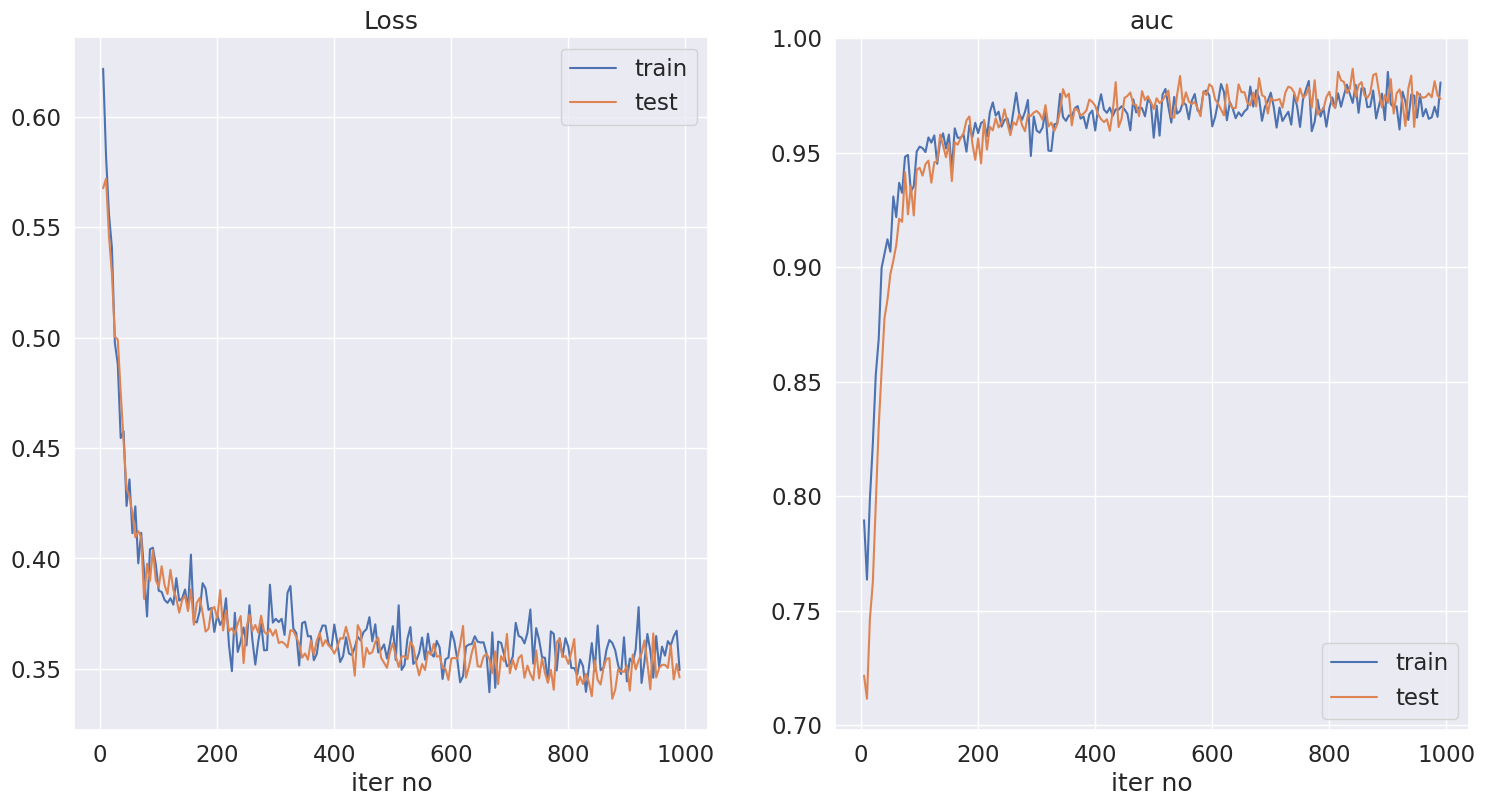

In [54]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 30, plot_iter = 5)

  0%|          | 0/4 [00:00<?, ?it/s]

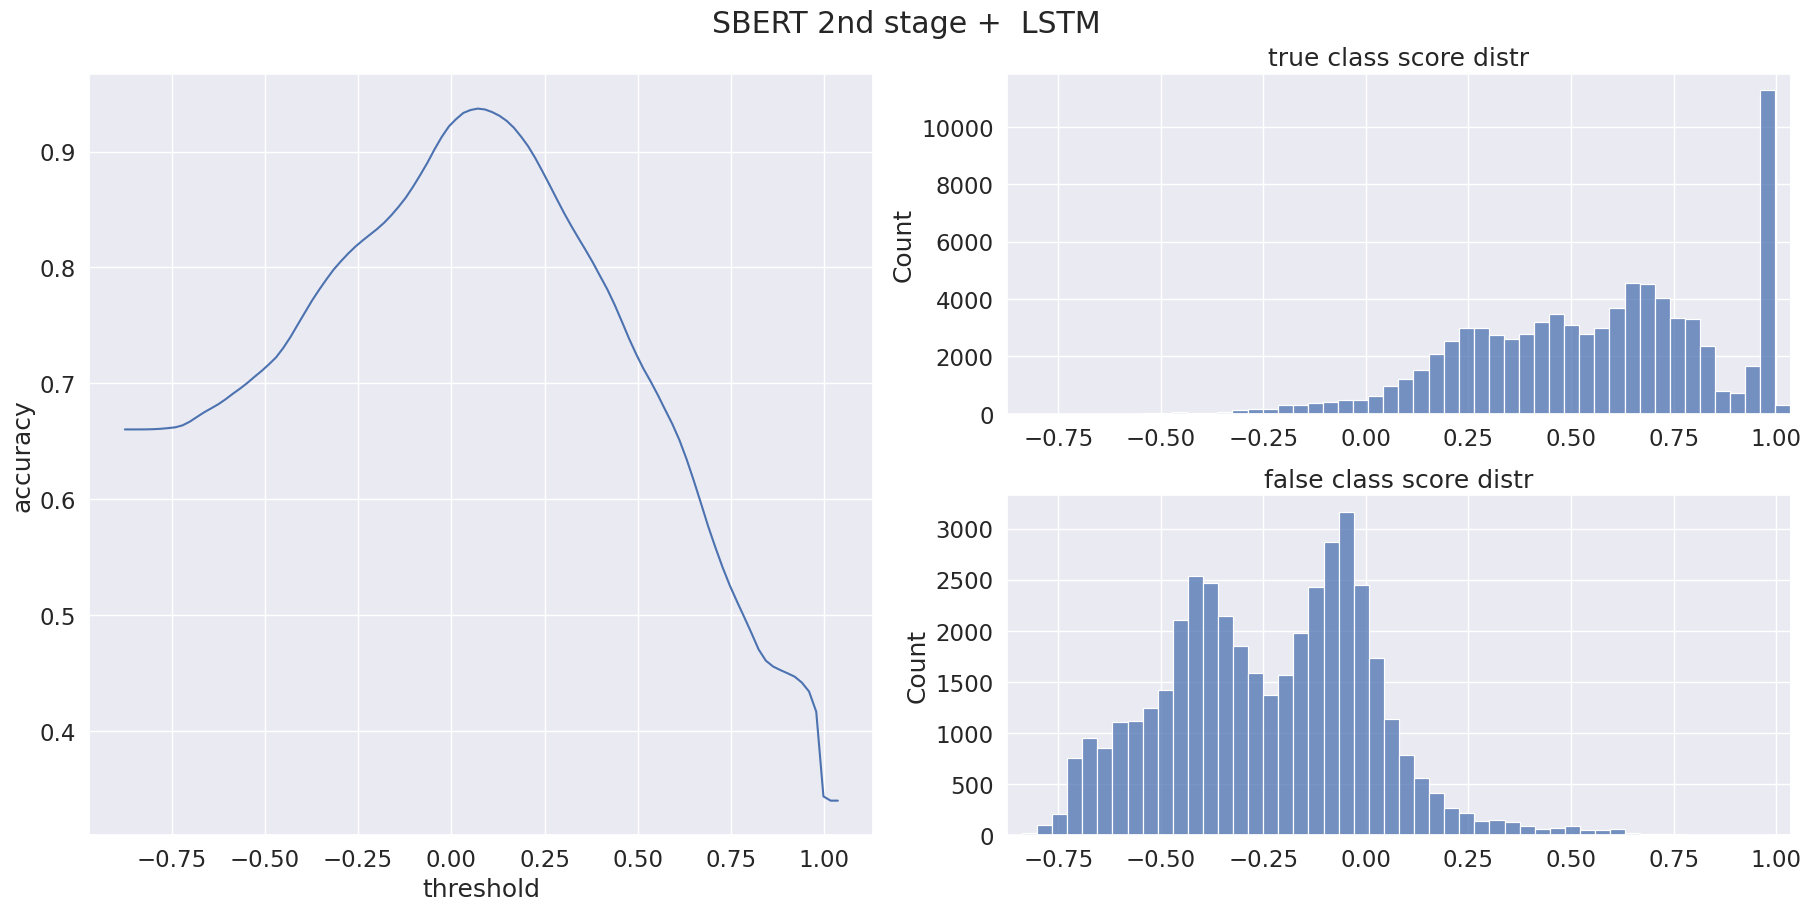

max acc: 0.937
class 1 prop : 0.6602200198851791


In [55]:
from dialogue_sim.utils import plot_pairwaise_class
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "SBERT 2nd stage +  LSTM")
res['SBERT 2nd stage + LSTM'] = max_acc

In [56]:
import torch.nn as nn
class DialSimLstmFFN(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.LSTM(input_size = 8, hidden_size = 64, num_layers = 1, bidirectional = True)
    self.l1 = nn.Linear(in_features= 128, out_features= 64)
  
  def forward(self, data):
    lengths = data['lengths'].cpu()
    emb = data['embeddings'].to(device).float()
    ps = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = False)
    x = torch.cat(tuple(self.rnn(ps)[1][1]), dim = -1)
    return self.l1(x)
  
model = DialSimLstmFFN().to(device)

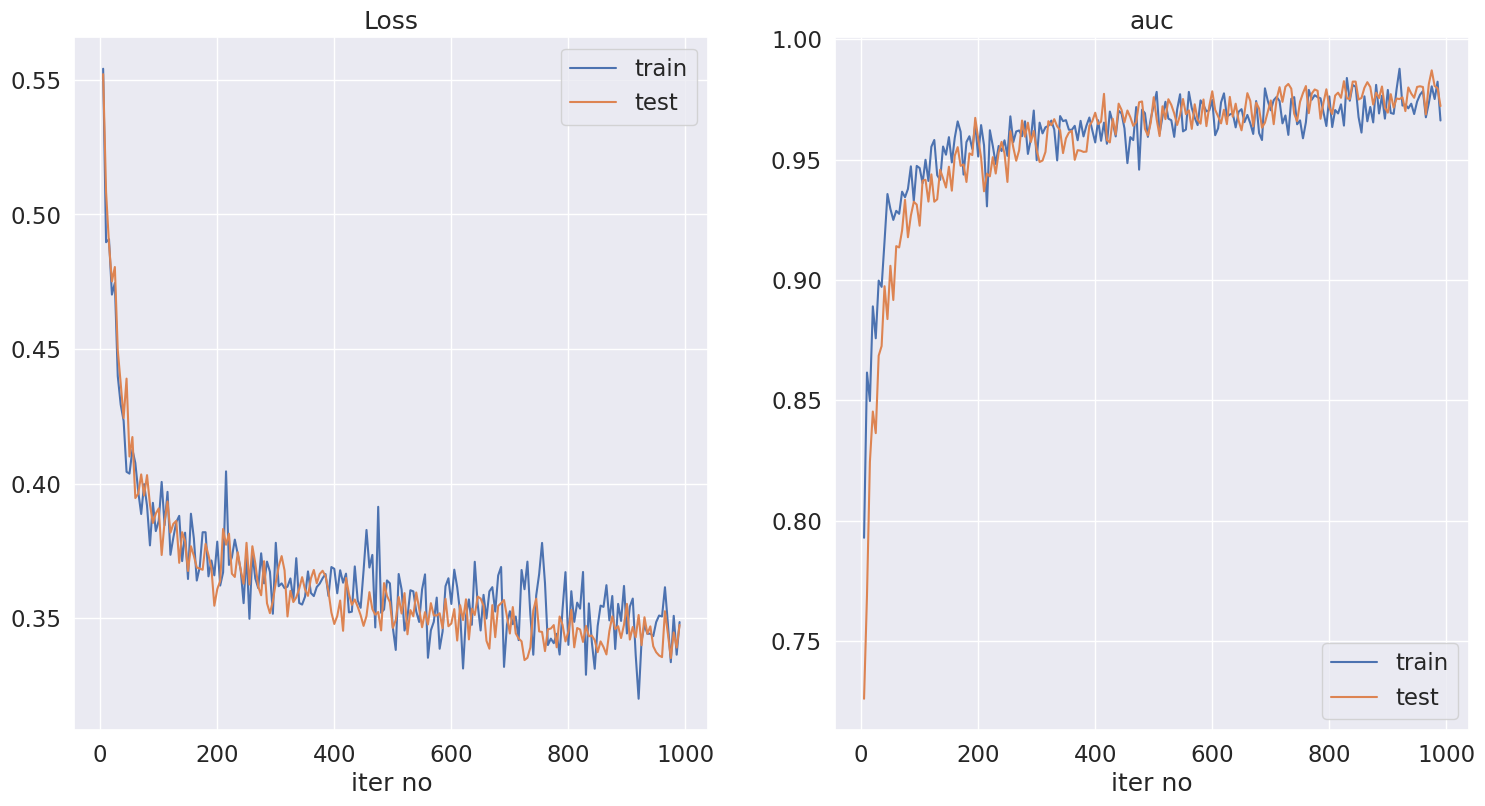

In [57]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 30, plot_iter= 5)

  0%|          | 0/4 [00:00<?, ?it/s]

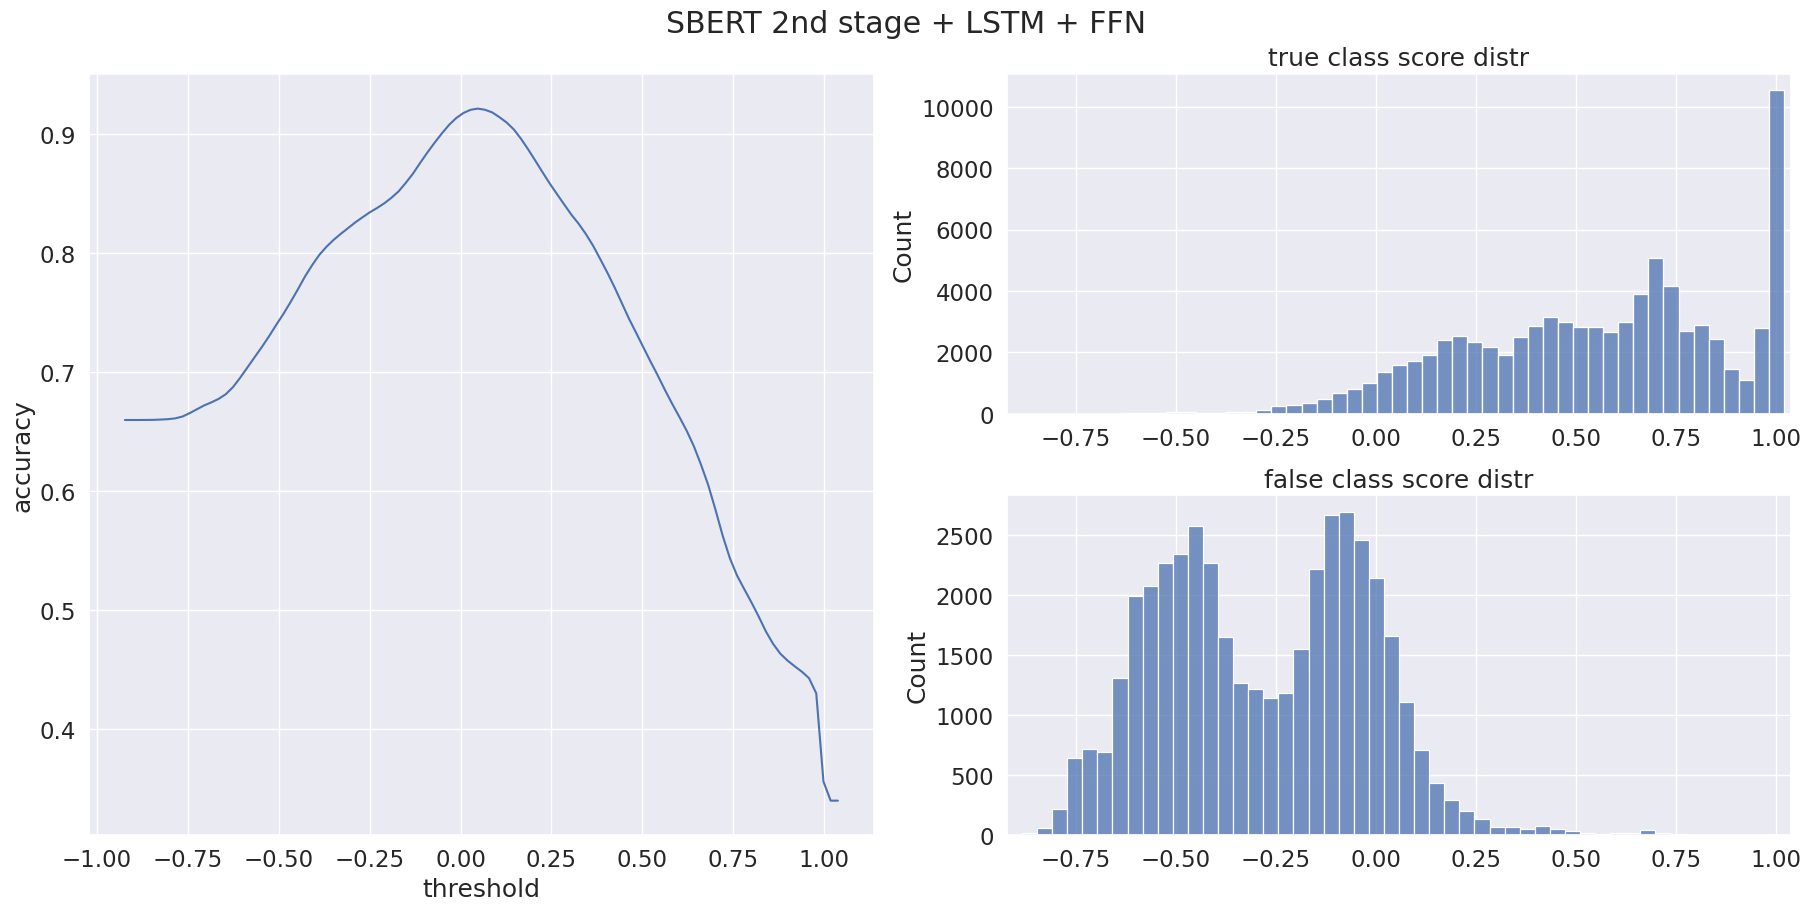

max acc: 0.922
class 1 prop : 0.6599233458417525


In [59]:
from dialogue_sim.utils import plot_pairwaise_class
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "SBERT 2nd stage + LSTM + FFN")
res['SBERT 2nd stage + LSTM + FNN'] = max_acc


In [66]:
import torch.nn as nn
class DialSimCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 5)
    self.act = nn.GELU()
    self.lin1 = nn.Linear(in_features = 16, out_features = 64)
    self.act2 = nn.GELU()
    self.lin2 = nn.Linear(in_features = 64, out_features = 32)
  
  def forward(self, data):
    emb = data['embeddings'].to(device).float()
    emb = emb.movedim(1, -1)
    x = self.conv(emb)
    x = x.mean(axis = -1)
    x = self.act(x)
    x = self.lin1(x)
    x = self.act2(x)
    x = self.lin2(x)
    return x
  
model = DialSimCNN().to(device)

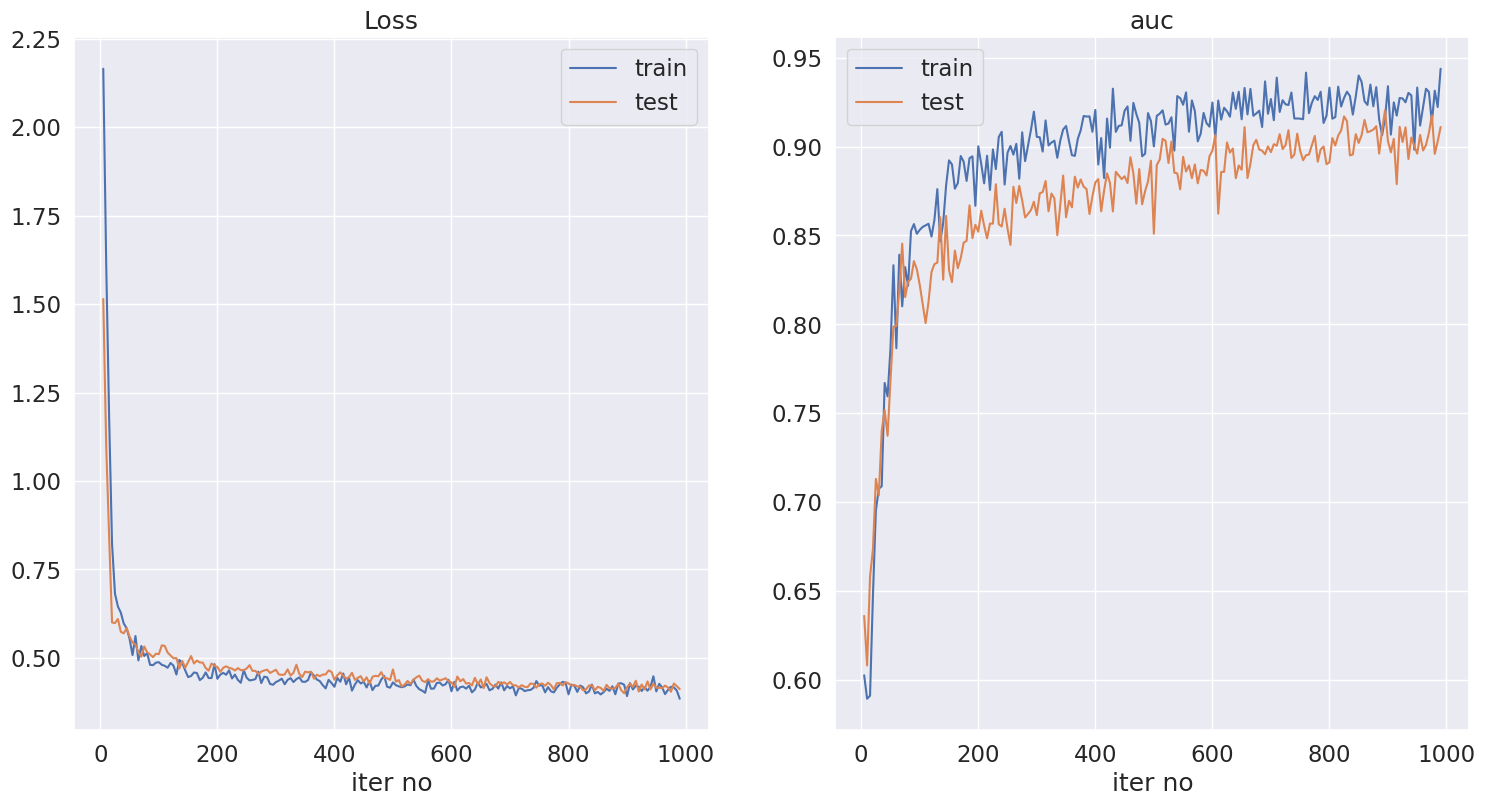

In [67]:
optimizer = torch.optim.Adam(model.parameters())
train_cycle(model, num_epochs = 30, plot_iter = 5)

  0%|          | 0/4 [00:00<?, ?it/s]

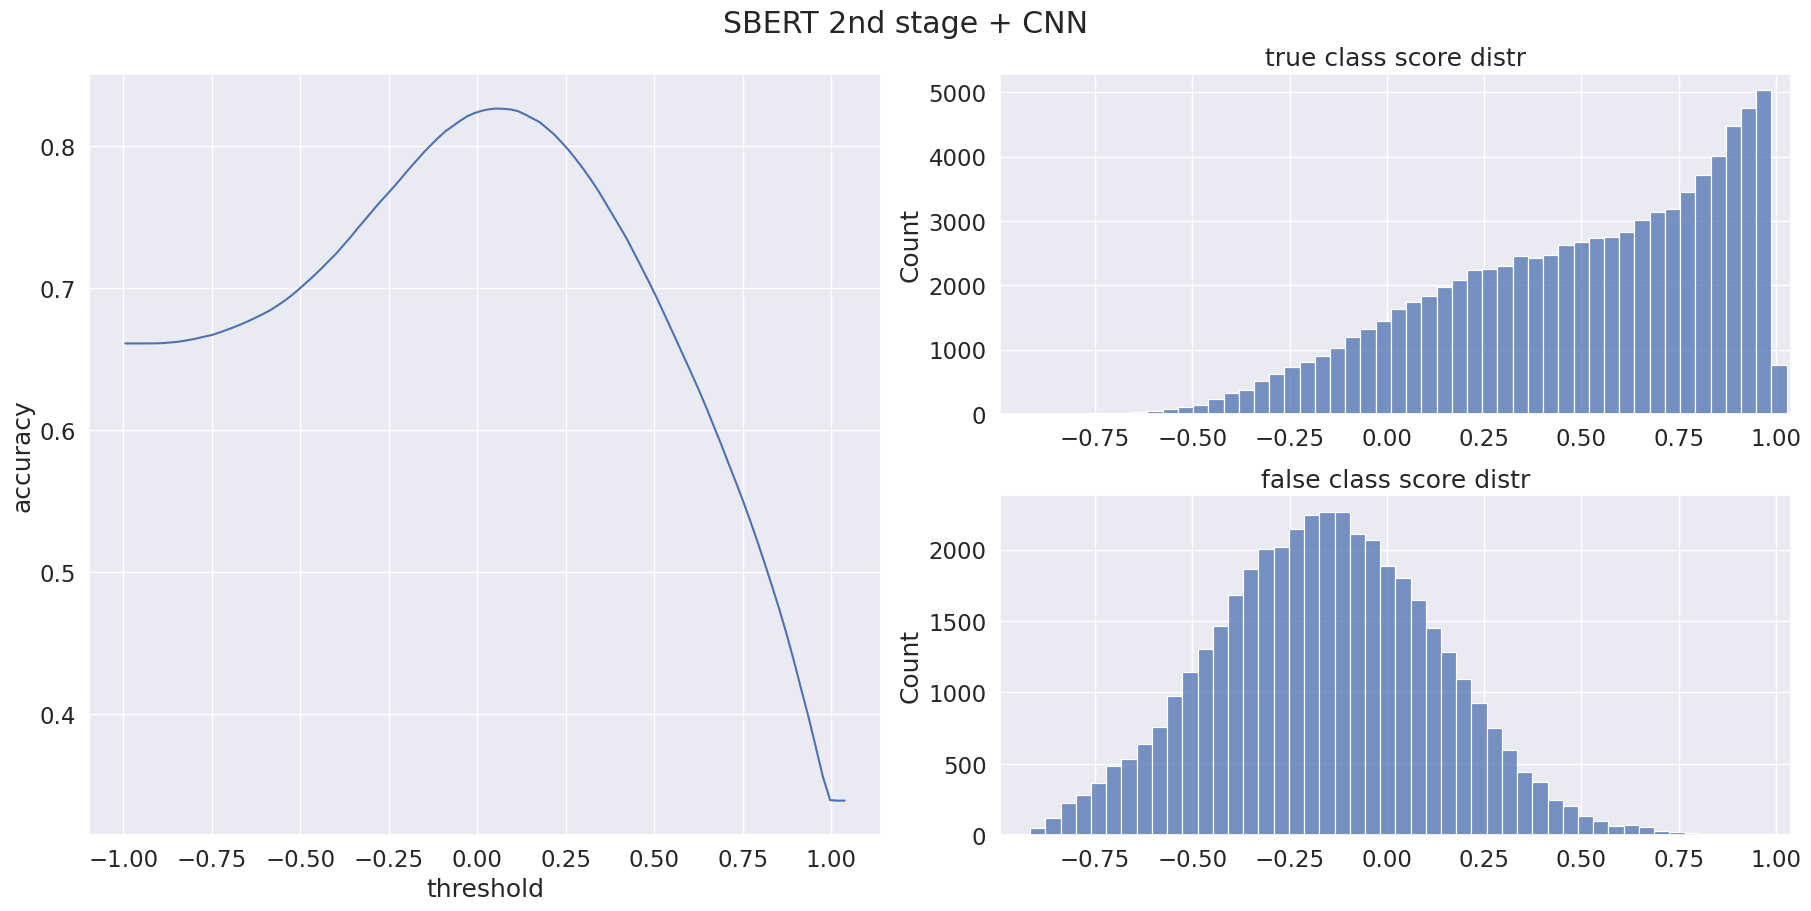

max acc: 0.827
class 1 prop : 0.6611581513197986


In [69]:
from dialogue_sim.utils import plot_pairwaise_class
scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "SBERT 2nd stage + CNN")
res['SBERT 2nd stage + CNN'] = max_acc

In [70]:
import numpy as np
from sklearn.metrics import roc_auc_score

def service_classification_metrics(sim_metric, test_data, num_repeats = 1000):
    n_dialogues = len(test_data)
    idxs = np.random.choice(range(n_dialogues), size = (num_repeats, 2))
    dialogues = [(test_data[i], test_data[j]) for (i, j) in idxs]
    services = [(dial[0]['services'], dial[1]['services']) for dial in dialogues]
    target = np.array([(serv[0] * serv[1]).sum() > 0 for serv in services]).astype('int')
    #target = np.array([set(serv[0]) == set(serv[1]) for serv in services]).astype('int')
    scores = []
    for i in range(num_repeats):
        metric = sim_metric(*dialogues[i])
        scores.append(metric)
    scores = np.array(scores)
    return roc_auc_score(target, scores), scores, target

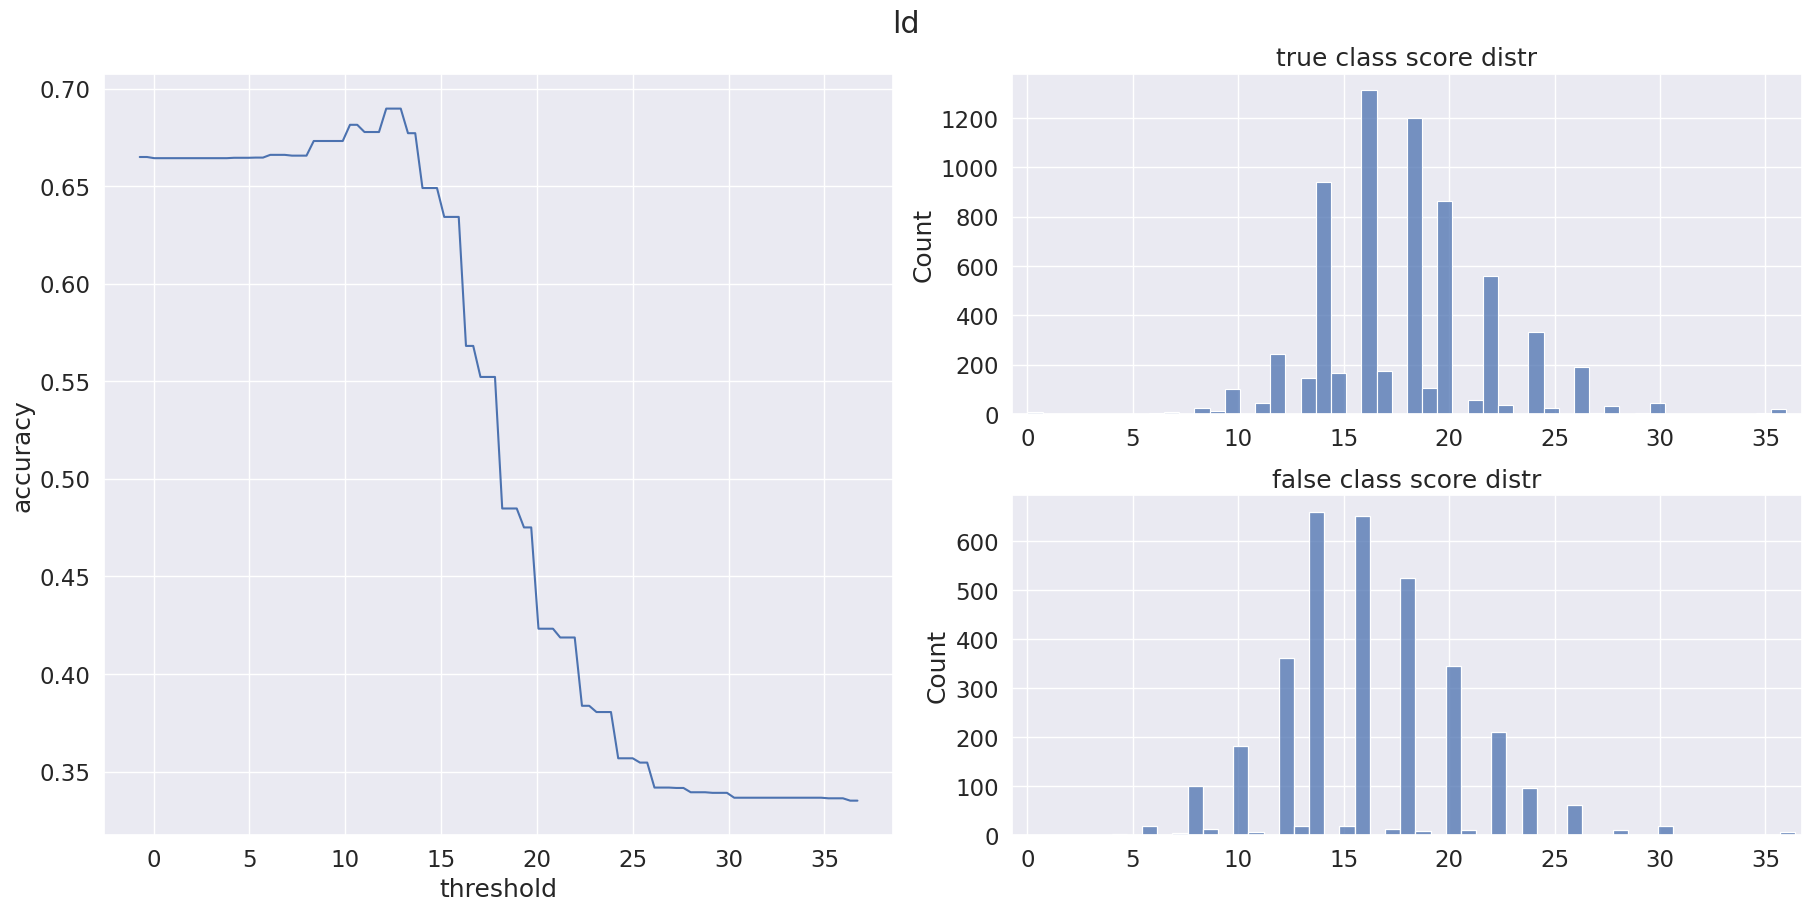

max acc: 0.690
class 1 prop : 0.6649


In [71]:
from dialogue_sim.utils import plot_pairwaise_class
from Levenshtein import distance

ld = lambda dial1, dial2 : distance(dial1['clusters'], dial2['clusters'])
auc, scores, target = service_classification_metrics(ld, test, 10000)
max_acc = plot_pairwaise_class(scores, target, "ld")
res['levenstein'] = max_acc

In [78]:
import pandas as pd

results = pd.DataFrame({'max acc' : res.values()})
results.index = res.keys()
results.sort_values('max acc', ascending = False)

,max acc
SBERT 2nd stage + GRU,0.952676
SBERT 2nd stage + GRU + FFN,0.940826
SBERT 2nd stage + LSTM,0.937161
SBERT 2nd stage + LSTM + FNN,0.921590
cluster + trained emb + GRU,0.879013
SBERT 2nd stage + RNN,0.865783
SBERT 2nd stage + FFN,0.855969
SBERT 2nd stage + CNN,0.826710
levenstein,0.689700
